# Projet 5 : Segmentez des clients d'un site e-commerce

On travaille comme consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.
Ma mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. On utilisera donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.
- Opérer une segmentation sur l’ensemble des clients:
- Une fois le modèle de segmentation choisi, proposer une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance;

## Sommaire:

## - I/ Importation du dataset
   
## - II/ Modélisations
### -          1-préparation
### -          2-a Kmeans avec dataset RFM (avec/sans normalisation)
### -          2-b Kmeans avec dataset RFM élargi (avec une feature en plus)
### -          3- DBScan Clustering avec dataset RFM élargi 
### -          4- Clustering Hiérarchique avec dataset RFM élargi 


## I/ Importation du dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns
from sklearn import metrics
import plotly.express as px
import plotly.graph_objs as go
##3D
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

from sklearn.base import BaseEstimator, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils.metaestimators import available_if
from sklearn.utils.validation import check_is_fitted



In [2]:
print("version numpy :" + np.__version__)
print("version pandas :" + pd.__version__)
print("version seaborn :" + sns.__version__)

version numpy :1.20.1
version pandas :1.2.4
version seaborn :0.11.1


In [3]:
data_nettoye = pd.read_csv("data_nettoye.csv", sep=",")

In [4]:
#on va supprimer les features qui ont une forte corrélation entre elles
data_nettoye = data_nettoye.drop(["price","Qty_pdt_customer","freight_value","order_id"], axis=1)

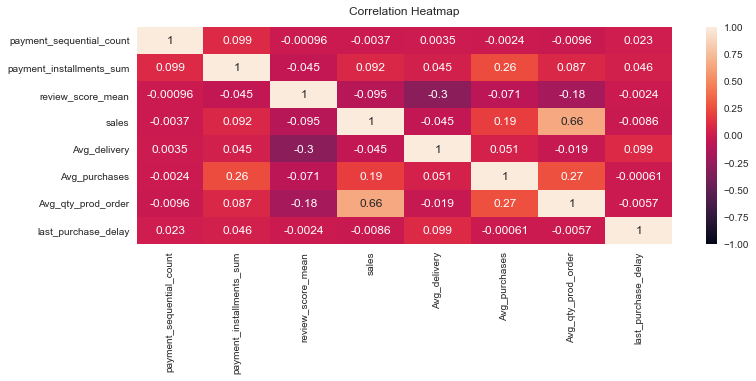

In [5]:
# taille de la heatmap.
plt.figure(figsize=(12, 4))
heatmap = sns.heatmap(data_nettoye.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [6]:
data_nettoye.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109413 entries, 0 to 109412
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_unique_id        109413 non-null  object 
 1   payment_sequential_count  109413 non-null  float64
 2   payment_installments_sum  109413 non-null  float64
 3   review_score_mean         109413 non-null  float64
 4   sales                     109413 non-null  float64
 5   Avg_delivery              109413 non-null  float64
 6   order_purchase_timestamp  109413 non-null  object 
 7   Avg_purchases             109413 non-null  float64
 8   Avg_qty_prod_order        109413 non-null  float64
 9   last_purchase_delay       109413 non-null  float64
dtypes: float64(8), object(2)
memory usage: 8.3+ MB


In [7]:
data_nettoye.head(5)

,customer_unique_id,payment_sequential_count,payment_installments_sum,review_score_mean,sales,Avg_delivery,order_purchase_timestamp,Avg_purchases,Avg_qty_prod_order,last_purchase_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0,8.0,5.0,5.0,6.0,2018-05-10 10:56:27,129.90,1.0,111.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,1.0,4.0,5.0,3.0,2018-05-07 11:11:27,18.90,1.0,114.0
2,0000f46a3911fa3c0805444483337064,1.0,8.0,3.0,3.0,25.0,2017-03-10 21:05:03,69.00,1.0,536.0
3,0000f6ccb0745a6a4b88665a16c9f078,1.0,4.0,4.0,10.0,20.0,2017-10-12 20:29:41,25.99,1.0,320.0
4,0004aac84e0df4da2b147fca70cf8255,1.0,6.0,5.0,11.0,13.0,2017-11-14 19:45:42,180.00,1.0,287.0


In [8]:
data_nettoye.describe()

,payment_sequential_count,payment_installments_sum,review_score_mean,sales,Avg_delivery,Avg_purchases,Avg_qty_prod_order,last_purchase_delay
count,109413.000000,109413.000000,109413.000000,109413.000000,109413.000000,109413.000000,109413.000000,109413.000000
mean,1.043962,3.063009,4.081747,9.047956,11.966183,151.223974,1.381619,235.806156
std,0.374020,2.804566,1.335390,10.093082,9.367192,252.505104,1.061479,152.175808
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.850000,1.000000,0.000000
25%,1.000000,1.000000,4.000000,4.000000,6.000000,49.800000,1.000000,113.000000
50%,1.000000,2.000000,5.000000,7.000000,10.000000,92.000000,1.000000,216.000000
75%,1.000000,4.000000,5.000000,11.000000,15.000000,161.900000,1.000000,343.000000
max,26.000000,26.000000,5.000000,198.000000,208.000000,13440.000000,21.000000,694.000000


In [9]:
data_nettoye.describe(include=['O'])

,customer_unique_id,order_purchase_timestamp
count,109413,109413
unique,92754,80902
top,c8460e4251689ba205045f3ea17884a1,"<DatetimeArray>\n[]\nLength: 0, dtype: datetim..."
freq,24,28324


In [10]:
data_nettoye.set_index('customer_unique_id', inplace=True)

In [11]:
data_nettoye.isna().sum()

payment_sequential_count    0
payment_installments_sum    0
review_score_mean           0
sales                       0
Avg_delivery                0
order_purchase_timestamp    0
Avg_purchases               0
Avg_qty_prod_order          0
last_purchase_delay         0
dtype: int64

In [12]:
data_nettoye.shape

(109413, 9)

In [13]:
data_nettoye.columns

Index(['payment_sequential_count', 'payment_installments_sum',
       'review_score_mean', 'sales', 'Avg_delivery',
       'order_purchase_timestamp', 'Avg_purchases', 'Avg_qty_prod_order',
       'last_purchase_delay'],
      dtype='object')

On va supprimer les variables qui ne sont pas pertinents.

In [14]:
data_nettoye.select_dtypes(['object']).nunique()

order_purchase_timestamp    80902
dtype: int64

Il y a une variable catégorielle : "order_purchase_timestamp".

# II-Modélisations

## 1-Préparation

Le dataset est déjà trop gros pour obtenir rapidement des résultats. Dans un premier temps, on va donc effectuer un sampling et travailler sur seulement 10000 clients afin d'avoir des temps d'execution des algos relativement rapide. Puis, on finalisera avec le dataset complet.

In [15]:
data_nettoye_bis = data_nettoye.copy()
data_sample = data_nettoye_bis.sample(109413, random_state=1).copy()

In [16]:
data_sample.shape

(109413, 9)

In [17]:
data_sample.dtypes

payment_sequential_count    float64
payment_installments_sum    float64
review_score_mean           float64
sales                       float64
Avg_delivery                float64
order_purchase_timestamp     object
Avg_purchases               float64
Avg_qty_prod_order          float64
last_purchase_delay         float64
dtype: object

In [18]:
data_sample.columns

Index(['payment_sequential_count', 'payment_installments_sum',
       'review_score_mean', 'sales', 'Avg_delivery',
       'order_purchase_timestamp', 'Avg_purchases', 'Avg_qty_prod_order',
       'last_purchase_delay'],
      dtype='object')

In [19]:
data_sample.isnull().sum()

payment_sequential_count    0
payment_installments_sum    0
review_score_mean           0
sales                       0
Avg_delivery                0
order_purchase_timestamp    0
Avg_purchases               0
Avg_qty_prod_order          0
last_purchase_delay         0
dtype: int64

In [20]:
num_columns = list(data_sample.select_dtypes(include=['int32','int64','float64']).columns)
# création instance StandardScaler
#sds = StandardScaler()
# création instance MinMaxScaler
mms = MinMaxScaler()
#effectuer une normalisation sur les colonnes 'num_columns'
#sample[num_columns] = sds.fit_transform(sample[num_columns])
preprocess = ColumnTransformer([('mms', mms, num_columns)])

- On va déterminer le meilleur K (avec la méthode du coude);
- Je vais utiliser un pipeline SKLearn pour y mettre le preprocessing et la méthode du coude de notre KMeans.
- on va dans un premier temps, l'appliquer sur 3 features (RFM) plus à un RFM amélioré (Avec une feature en plus).

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

## 2-Kmeans Clustering

### 2-a-Kmeans avec dataset  RFM

In [21]:
X = data_sample.copy()
X_rfm = X[["Avg_purchases", "last_purchase_delay", "Avg_qty_prod_order"]].copy()

In [23]:
data_rfm = pd.DataFrame(columns = ["Feature", "Description"], index = ["La récence : ", "La fréquence : ", 
                                                                       "Le montant : ", "Feature supp"])
data_rfm["Feature"] = ["last_purchase_delay" ,"Avg_qty_prod_order", "Avg_purchases ", "review_score_mean"]
data_rfm["Description"] = ["C'est le délai depuis le dernier achat " ,
                           "C’est la quantité moyenne de produits par cde", 
                           "C’est le montant d'achat moyen", 
                           "C’est la note moyenne"]
data_rfm

,Feature,Description
La récence :,last_purchase_delay,C'est le délai depuis le dernier achat
La fréquence :,Avg_qty_prod_order,C’est la quantité moyenne de produits par cde
Le montant :,Avg_purchases,C’est le montant d'achat moyen
Feature supp,review_score_mean,C’est la note moyenne


In [20]:
X_rfm.head(4)

,Avg_purchases,last_purchase_delay,Avg_qty_prod_order
customer_unique_id,,,
dab0534f26716b89fab0a6ccdb8de10a,49.90,227.0,1.0
fc55cc53b529023f0c785f21e9b73137,34.90,194.0,1.0
d0972d0443d22c762575dcfbc3eb8b0a,69.90,454.0,1.0
c18af2b8420b8fc5dc5d9f3a627257ae,33.99,42.0,1.0


### On va tester les résultats avec et sans normalisation des données pour juger de la pertinence de la normalisation

### Avec  normalisation
On va normaliser les données pour qu'elles prennent toutes la même importance.

In [34]:
num_columns =["Avg_purchases", "last_purchase_delay", "Avg_qty_prod_order"]
from sklearn import preprocessing
#X_norm = MinMaxScaler().fit_transform(X)
X_rfm_norm = MinMaxScaler().fit_transform(X_rfm)
X_rfm_norm = pd.DataFrame(X_rfm_norm, index=X_rfm.index, columns=X_rfm.columns)
X_rfm_norm.head(3)

,Avg_purchases,last_purchase_delay,Avg_qty_prod_order
customer_unique_id,,,
dab0534f26716b89fab0a6ccdb8de10a,0.003650,0.327089,0.0
fc55cc53b529023f0c785f21e9b73137,0.002534,0.279539,0.0
d0972d0443d22c762575dcfbc3eb8b0a,0.005138,0.654179,0.0



On va maintenant faire un clustering kmeans, pour plusieurs tailles de clusters, pour chacune de ces tailles je vais calculer le coef de silhouette pour ensuite choisir la taille de cluster la plus appropriée.

Populating the interactive namespace from numpy and matplotlib


/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['fft', 'power', 'linalg', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


K :9
Durée d'exécution :0:21:27.342701




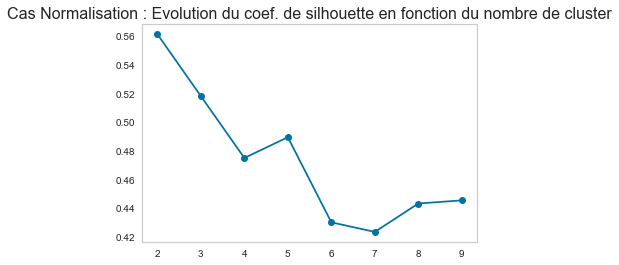

In [25]:
%pylab inline
from sklearn import cluster, metrics #module pour faire du clustering et module pour calculer le coef de silhouette
import time
from datetime import timedelta

start_time = time.monotonic()

silhouettes = []
for num_cluster in range(2,10): # on regarde de 2 à 10 clusters
    cls = cluster.KMeans(n_clusters=num_cluster, 
                         n_init=1, init="random" )# initialisation aléatoire et unique
    cls.fit(X_rfm_norm) #on va faire le clustering sur les données normalisées
    silh = metrics.silhouette_score(X_rfm_norm, cls.labels_)# on va calculer le coef de silhouette, sur les données X_norm, etant donné le clustering fourni par cls.labels.
    silhouettes.append(silh)
    
plt.title("Cas Normalisation : Evolution du coef. de silhouette en fonction du nombre de cluster", fontsize=16)    
plt.plot(range(2,10), silhouettes, marker='o')
print("K :"+str(num_cluster))
#print("coef Silhouette :"+str(silh))
end_time = time.monotonic()
print("Durée d'exécution :" +str(timedelta(seconds=end_time - start_time)))
print("")
print("")

Le coef de silhouette décroit globalement avec le nombre de cluster, mais augmente pour 4 et 7. Ce graphique indique qu'il nous faut priviléger 3 ou 4 clusters des valeurs pour lesquelles le coef de silhouette, est le plus élévé. On va prendre K=4.

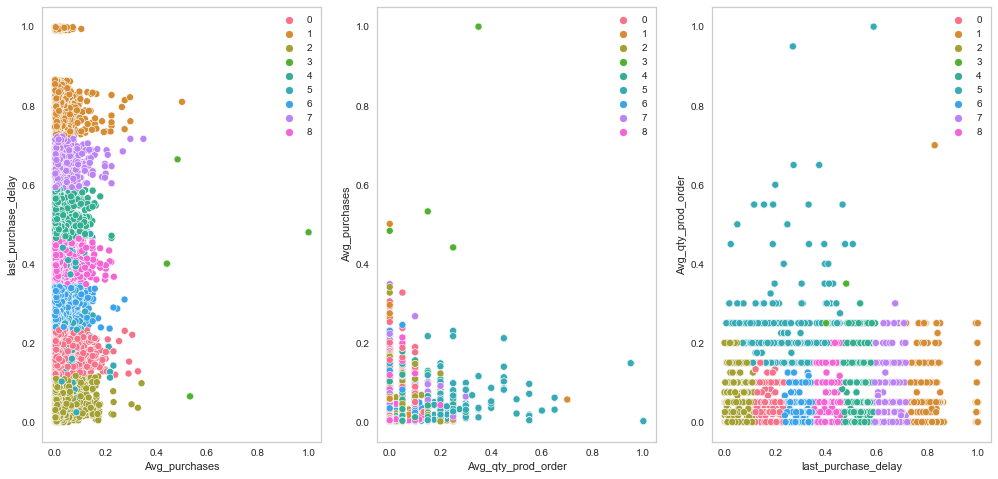

In [26]:
fig = plt.figure(figsize=(17, 8))
fig.add_subplot(131)
sns.scatterplot(x=X_rfm_norm["Avg_purchases"],y=X_rfm_norm["last_purchase_delay"],hue=cls.labels_, legend='full', palette=sns.color_palette("husl",9))
#plt.title("Répartition du montant des achats en fonction du délai de livraison", fontsize=16)
fig.add_subplot(132)
sns.scatterplot(x=X_rfm_norm["Avg_qty_prod_order"],y=X_rfm_norm["Avg_purchases"],hue=cls.labels_, legend='full', palette=sns.color_palette("husl",9))
#plt.title("Répartition du nombre de produits par commande en fonction du montant des achats", fontsize=16)
fig.add_subplot(133)
sns.scatterplot(x=X_rfm_norm["last_purchase_delay"],y=X_rfm_norm["Avg_qty_prod_order"],hue=cls.labels_, legend='full', palette=sns.color_palette("husl",9))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

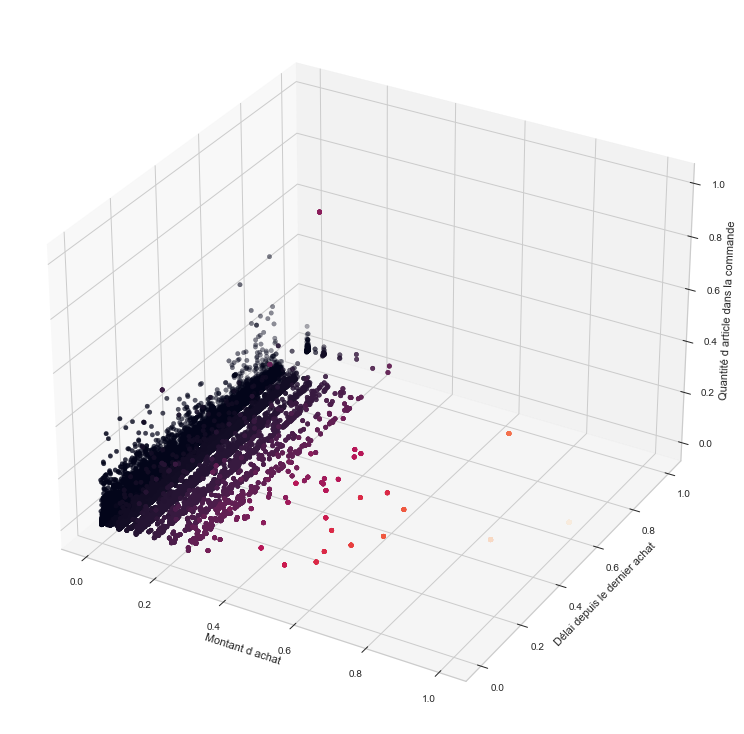

In [27]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig) # Method 1
#ax = fig.add_subplot(111, projection='3d') # Method 2

z = X_rfm_norm["Avg_purchases"]
y = X_rfm_norm["last_purchase_delay"]
x = X_rfm_norm["Avg_qty_prod_order"]

ax.scatter(x, y, z,c=x, marker='o')
ax.set_xlabel('Montant d achat')
ax.set_ylabel('Délai depuis le dernier achat')
ax.set_zlabel('Quantité d article dans la commande')

plt.show()

## Interprétation des clusters en les caratérisants

- Cluster 0 : Clients ayant des délais depuis le dernier achat qui sont moyennement long pour des montants d'achats moyen. Ils commandent moyennement d'articles à chaque commande. 
- Cluster 1 : Clients ayant des délais depuis le dernier achat qui sont faibles pour des montants d'achats moyen et quelques clients avec des forts montants. Ils commandent moyennement d'articles à chaque commande. 
- Cluster 2 : Clients ayant des délais depuis le dernier achat qui sont très long pour des montants moyens. Ils commandent moyennement d'articles à chaque commande. 
- Cluster 3 : Clients ayant des délais depuis le dernier achat qui sont long pour des montants moyens. Ils commandent moyennement d'articles à chaque commande. 

### Sans  normalisation

Populating the interactive namespace from numpy and matplotlib
K :9
Durée d'exécution :0:21:54.594913




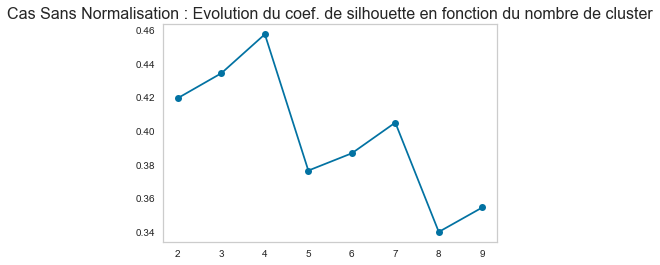

In [28]:
%pylab inline
from sklearn import cluster, metrics
import time
from datetime import timedelta

start_time = time.monotonic()

silhouettes_s = []
for num_cluster in range(2,10):
    cls_s = cluster.KMeans(n_clusters=num_cluster, 
                         n_init=1, init="random" )
    cls_s.fit(X_rfm) #on va faire le clustering sur les données non normalisées
    silh_s = metrics.silhouette_score(X_rfm, cls_s.labels_)
    silhouettes_s.append(silh_s)
plt.title("Cas Sans Normalisation : Evolution du coef. de silhouette en fonction du nombre de cluster", fontsize=16)    
plt.plot(range(2,10), silhouettes_s, marker='o')
print("K :"+str(num_cluster))

end_time = time.monotonic()
print("Durée d'exécution :" +str(timedelta(seconds=end_time - start_time)))
print("")
print("")

Le coef de silhouette ne décroit pas de manière régulière avec le nombre de cluster. Ce graphique indique qu'il nous faut priviléger 3 ou 4 clusters des valeurs pour lesquelles le coef de silhouette, est le plus élévé. On va prendre K=9.

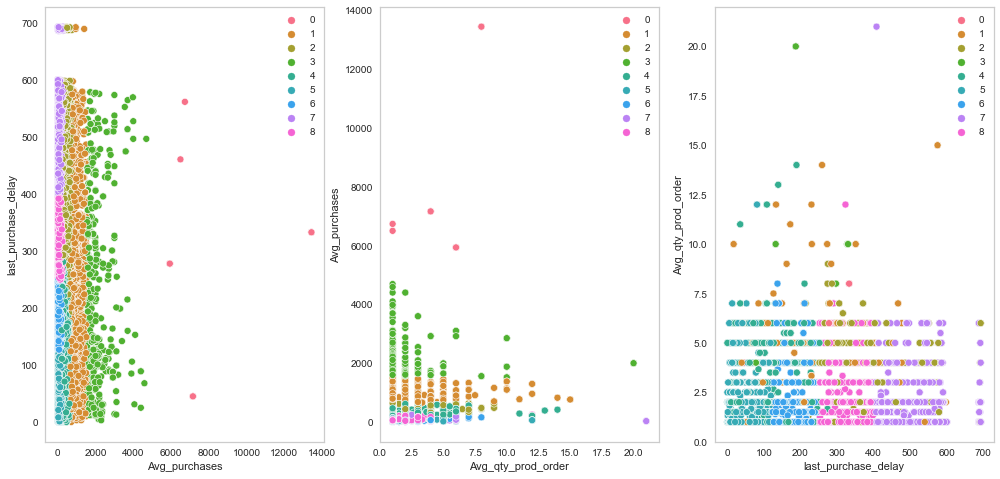

In [29]:
fig = plt.figure(figsize=(17, 8))
fig.add_subplot(131)
sns.scatterplot(x=X_rfm["Avg_purchases"],y=X_rfm["last_purchase_delay"],hue=cls_s.labels_, legend='full', palette=sns.color_palette("husl",9))
#plt.title("Répartition du montant des achats en fonction du délai de livraison", fontsize=16)
fig.add_subplot(132)
sns.scatterplot(x=X_rfm["Avg_qty_prod_order"],y=X_rfm["Avg_purchases"],hue=cls_s.labels_, legend='full', palette=sns.color_palette("husl",9))
#plt.title("Répartition du nombre de produits par commande en fonction du montant des achats", fontsize=16)
fig.add_subplot(133)
sns.scatterplot(x=X_rfm["last_purchase_delay"],y=X_rfm["Avg_qty_prod_order"],hue=cls_s.labels_, legend='full', palette=sns.color_palette("husl",9))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

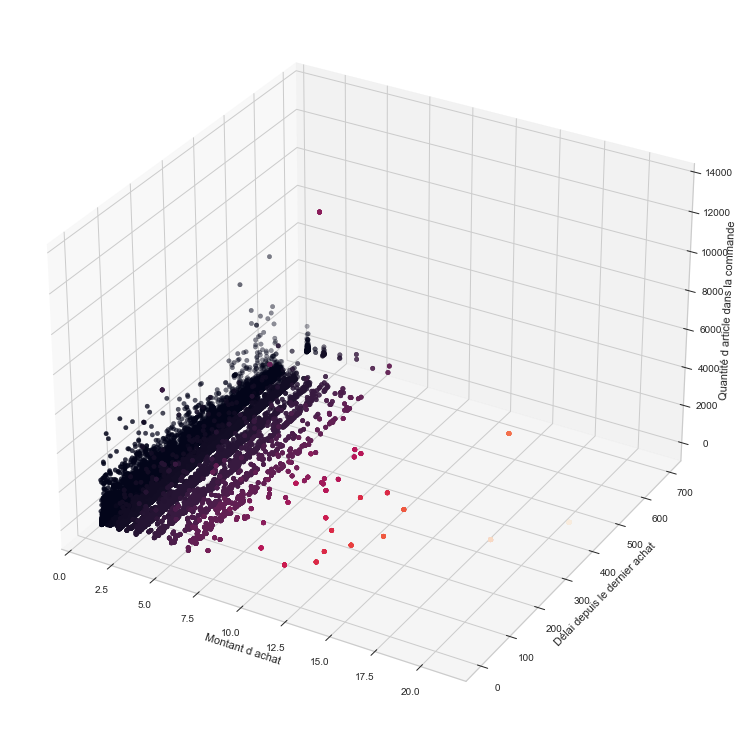

In [30]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig) # Method 1
#ax = fig.add_subplot(111, projection='3d') # Method 2

z = X_rfm["Avg_purchases"]
y = X_rfm["last_purchase_delay"]
x = X_rfm["Avg_qty_prod_order"]

ax.scatter(x, y, z,c=x, marker='o')
ax.set_xlabel('Montant d achat')
ax.set_ylabel('Délai depuis le dernier achat')
ax.set_zlabel('Quantité d article dans la commande')

plt.show()

## Interprétation des clusters en les caratérisants

- Cluster 0 : Clients ayant des délais depuis le dernier achat qui sont moyennement long pour des montants d'achats moyen. Ils commandent moyennement d'articles à chaque commande. 
- Cluster 1 : Clients ayant des délais depuis le dernier achat qui sont faibles pour des montants d'achats moyen et quelques clients avec des forts montants. Ils commandent moyennement d'articles à chaque commande. 
- Cluster 2 : Clients ayant des délais depuis le dernier achat qui sont très long pour des montants moyens. Ils commandent moyennement d'articles à chaque commande. 
- Cluster 3 : Clients ayant des délais depuis le dernier achat qui sont long pour des montants moyens. Ils commandent moyennement d'articles à chaque commande. 

### Résultats:
- On constate que la normalisation des données améliore le temps d'exécution des calculs.
    - avec normalisation : 22'59''
    - sans normalisation : 23'45''
- On n'a pas de changement au niveau des clusters.
- On va appliquer la normalisation aux données pour la suite du projet.

### 2-b-Kmeans avec un dataset RFM élargi (avec une feature en plus)

In [92]:
#On va garder le dataset RFM mais on va ajouter la feature review score pour améliorer l'interprétation
#X_rfm_rs = X[["Avg_purchases", "last_purchase_delay", "Avg_qty_prod_order", "review_score_mean"]].copy()
X_rfm_rs = X.copy(deep=True)
X_rfm_rs= X_rfm_rs.drop(['payment_sequential_count', 'payment_installments_sum','sales', 'Avg_delivery',
                         'order_purchase_timestamp'], axis=1)

In [93]:
X_rfm_rs.shape

(109413, 4)

In [94]:
X_rfm_rs.head(1)

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay
customer_unique_id,,,,
dab0534f26716b89fab0a6ccdb8de10a,5.0,49.9,1.0,227.0


In [95]:
X_rfm_rs.dtypes

review_score_mean      float64
Avg_purchases          float64
Avg_qty_prod_order     float64
last_purchase_delay    float64
dtype: object

In [96]:
nume_columns = list(X_rfm_rs.select_dtypes(include=['int32','int64','float64']).columns)
mms = MinMaxScaler()
preprocess = ColumnTransformer([('mms', mms, nume_columns)])

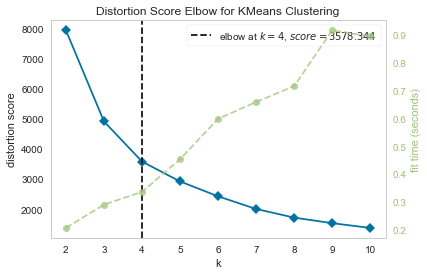

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
kmeans_visu = Pipeline([("preprocessing", preprocess),("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(2,10)))])
kmeans_visu.fit(X_rfm_rs)
kmeans_visu.named_steps['kelbowvisualizer'].show()

Par la méthode du coude basée sur le score de distorsion, K=4 clusters seraient une bonne segmentation.
- distorsion score : Somme du carré de la distance de chaque exemple à son centre de cluster le plus proche;

On va appliquer SilhouetteVisualizer pour trouver le coefficient de silhouette (visualiser la densité et la séparation des clusters).

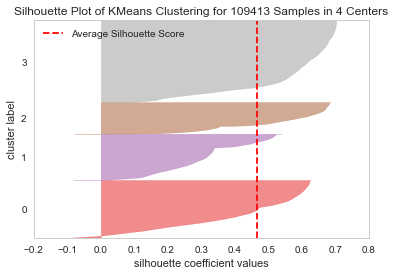

0:05:52.052502


In [98]:
from datetime import timedelta
start_time = time.monotonic()
# On a un K optimisé de la méthode du coude, soit K=4 clusters
K = kmeans_visu.named_steps['kelbowvisualizer'].elbow_value_
# On utilise SilhouetteVisualizer
silhouette_visu = Pipeline([("preprocessing", preprocess),("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visu.fit(X_rfm_rs)
silhouette_visu.named_steps['silhouettevisualizer'].show()
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Ici, on constate une assez bonne répartition des clusters.
A présent, nous allons tester d'autres types de métriques pour trouver le meilleur K :
Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,
Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes.

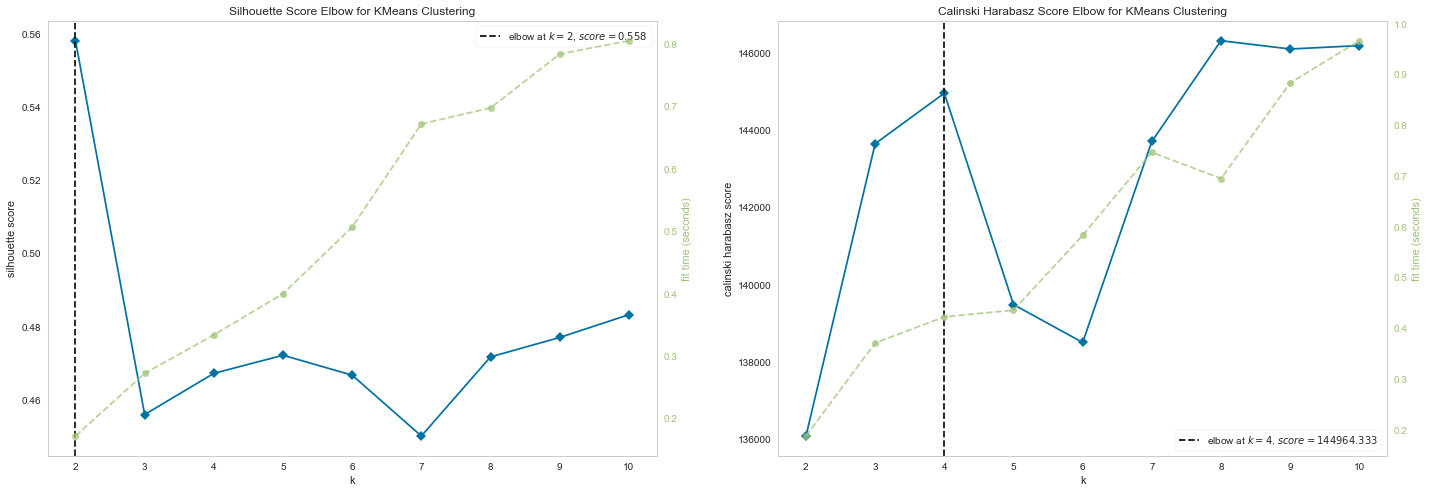

0:24:35.522707


In [99]:
from datetime import timedelta
start_time = time.monotonic()
# différentes métriques pour optimiser K
metrics = ["silhouette", "calinski_harabasz"]
#calinski_harabasz : Le score est défini comme le rapport de la somme de la dispersion inter-cluster et de la dispersion intra-cluster.
#silhouette : Le score est défini comme la distance moyenne inter-cluster et la distance moyenne au cluster le plus proche pour chaque échantillon.
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visu = Pipeline([("preprocessing", preprocess),("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(2,10),
                                                                                                metric=m,
                                                                                                ax=axes[i]))])
    kmeans_visu.fit(X_rfm_rs)
    kmeans_visu.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

On remarque ici que pour la métrique silhouette score, le nombre de K est de 2. Pour le score Calinski Harabasz, le meilleur K est de 4. 
Les scores sur la répartition (précédente) en 4 clusters semblent être meilleurs. Nous allons donc conserver ce clustering en 4 groupes

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:506: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



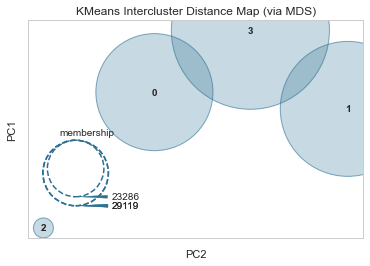

0:00:00.853884


In [100]:
from datetime import timedelta
start_time = time.monotonic()
# Intercluster distance
distance_visu = Pipeline([("preprocessing", preprocess), ("distancevisu", InterclusterDistance(KMeans(K)))])
distance_visu.fit(X_rfm_rs)
distance_visu.named_steps['distancevisu'].show()
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

Sur cette projection en 2D, on remarque que les principaux clusters sont regroupés sur les 2 premières composantes principales et un autre qui est diagonalement opposé (mais plus petit). Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.
Analyse des différents clusters
A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :

In [101]:
# KMeans avec Pipeline
kmeans_mod = Pipeline([("preprocessing", preprocess),("kmeans", KMeans(K))])
kmeans_mod.fit(X_rfm_rs)

# Kmeans labels
kmeans_labels = kmeans_mod.named_steps['kmeans'].labels_
X_rfm_rs["kmeans_label"] = kmeans_labels

In [102]:
X_rfm_rs["kmeans_label"]

customer_unique_id
dab0534f26716b89fab0a6ccdb8de10a    3
fc55cc53b529023f0c785f21e9b73137    3
d0972d0443d22c762575dcfbc3eb8b0a    0
c18af2b8420b8fc5dc5d9f3a627257ae    1
aab579a39b1b5c223c2e1a4bbf8ff977    1
                                   ..
753425bfd7cbc85577b8fafa451d2b26    3
e515dfc7b46b0281f0462ef9be3823f8    2
0beeacb8096bdcd8b00d9630eb264192    3
b5b5688f8bef64161d107275f14f914f    2
e64269d4e5997521884e61069f671fc8    0
Name: kmeans_label, Length: 109413, dtype: int32

On va regrouper les clients par clusters.

In [103]:
kmeans_groupe = X_rfm_rs.groupby("kmeans_label").mean().reset_index()
kmeans_groupe

,kmeans_label,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay
0,0,3.632905,145.760336,1.379710,175.886994
1,1,1.244192,196.325765,1.829702,234.529449
2,2,4.720834,146.385895,1.299341,415.918815
3,3,4.992549,140.079391,1.266236,134.537165


In [104]:
kmeans_groupe.dtypes

kmeans_label             int64
review_score_mean      float64
Avg_purchases          float64
Avg_qty_prod_order     float64
last_purchase_delay    float64
dtype: object

In [105]:
X_rfm_rs.head(3)

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay,kmeans_label
customer_unique_id,,,,,
dab0534f26716b89fab0a6ccdb8de10a,5.0,49.9,1.0,227.0,3
fc55cc53b529023f0c785f21e9b73137,5.0,34.9,1.0,194.0,3
d0972d0443d22c762575dcfbc3eb8b0a,3.0,69.9,1.0,454.0,0


In [106]:
#X_scaled = preprocess.fit_transform(X.values)
X_scaled = MinMaxScaler().fit_transform(X_rfm_rs)
X_scaled = pd.DataFrame(data=X_scaled, index=X_rfm_rs.index, columns=X_rfm_rs.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_groupe = X_scaled.groupby("kmeans_label").mean()
X_scaled_groupe
#X_scaled.head(5)

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay
kmeans_label,,,,
0,0.658226,0.010783,0.018986,0.253439
1,0.061048,0.014545,0.041485,0.337939
2,0.930208,0.010829,0.014967,0.599307
3,0.998137,0.010360,0.013312,0.193858


In [107]:
X_scaled_groupe.columns[1:]

Index(['Avg_purchases', 'Avg_qty_prod_order', 'last_purchase_delay'], dtype='object')

In [108]:
group="kmeans_label"
#X_scaled_groupe[X_scaled_groupe[group]==1].iloc[:,1:].values.reshape(-1)
X_scaled_groupe[X_scaled_groupe["Avg_purchases"]==1].iloc[:,1:].values.reshape(-1)

array([], dtype=float64)

## Description actionable de notre segmentation 

## - Nombre de clients par cluster

In [109]:
cluster = []
for i in range(4):
    cluster.append(X_rfm_rs.loc[X_scaled["kmeans_label"] == i])

In [110]:
a = 0
for i in range(4):
    b = cluster[i].shape[0]
    a += b
    print('cluster {} : {} clients'.format(i,b))

cluster 0 : 23335 clients
cluster 1 : 15926 clients
cluster 2 : 30289 clients
cluster 3 : 39863 clients


On a globalement une bonne répartition des clients dans les clusters. On a respectivement 21, 15, 27 et 37,5% pour les clusters 0,1,2 et 3.

## On va chercher à connaitre les clients qui dépensent le plus.

In [111]:
cust_spend = X_rfm_rs.drop(['review_score_mean', 'Avg_qty_prod_order', 'last_purchase_delay'], 
                      axis=1).groupby('kmeans_label').sum()

In [112]:
cust_spend.columns = ['total_amount']

In [113]:
cust_spend

,total_amount
kmeans_label,
0,3.401317e+06
1,3.126684e+06
2,4.433882e+06
3,5.583985e+06


In [114]:
cust_spend['number_of_customers'] = X_rfm_rs.groupby('kmeans_label').count().mean(axis=1)

In [115]:
cust_spend['amount_per_customer'] = cust_spend['total_amount']/cust_spend['number_of_customers']

Text(0.5, 1.0, "Répartition du nombre d'articles par cluster")

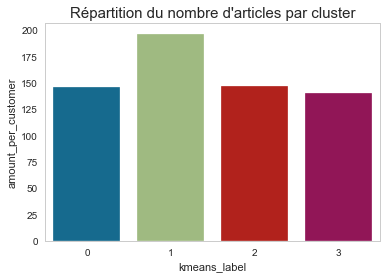

In [116]:
cust_spend.sort_values(by='amount_per_customer', inplace=True)
sns.barplot(x = cust_spend.index,y = cust_spend['amount_per_customer'])
plt.title("Répartition du nombre d'articles par cluster", fontsize=15)

- Le cluster 1 correspond aux clients qui dépensent le plus.

In [117]:
#Caratéristiques des clients selon les features du cluster 1
cluster[1].describe()

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay,kmeans_label
count,15926.000000,15926.000000,15926.000000,15926.000000,15926.0
mean,1.244192,196.325765,1.829702,234.529449,1.0
std,0.432815,427.112315,1.721850,139.915746,0.0
min,1.000000,3.540000,1.000000,0.000000,1.0
25%,1.000000,57.900000,1.000000,136.000000,1.0
50%,1.000000,110.000000,1.000000,210.000000,1.0
75%,1.000000,199.700000,2.000000,311.000000,1.0
max,2.500000,13440.000000,21.000000,694.000000,1.0


## A contrario, on va chercher à connaitre les clients qui dépensent le moins.

In [118]:
#Caratéristiques des clients selon les features du cluster 3
cluster[3].describe()

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay,kmeans_label
count,39863.000000,39863.000000,39863.000000,39863.000000,39863.0
mean,4.992549,140.079391,1.266236,134.537165,3.0
std,0.061336,201.899028,0.761861,80.854226,0.0
min,4.250000,0.850000,1.000000,0.000000,3.0
25%,5.000000,48.900000,1.000000,64.000000,3.0
50%,5.000000,89.900000,1.000000,130.000000,3.0
75%,5.000000,152.450000,1.000000,204.000000,3.0
max,5.000000,4590.000000,10.000000,277.000000,3.0


## On va regarder les clients qui ont acheté le plus d'articles.

In [119]:
qty_prod = X_rfm_rs.drop(['review_score_mean', 'Avg_purchases', 'last_purchase_delay'], 
                      axis=1).groupby('kmeans_label').sum()

In [120]:
qty_prod.columns = ['total_items']

In [121]:
#qty_prod

In [122]:
qty_prod['number_of_customers'] = X_rfm_rs.groupby('kmeans_label').count().mean(axis=1)

In [123]:
qty_prod['qty_per_customer'] = qty_prod['total_items']/qty_prod['number_of_customers']

In [124]:
#qty_prod

Text(0.5, 1.0, "Répartition du nombre d'articles par cluster")

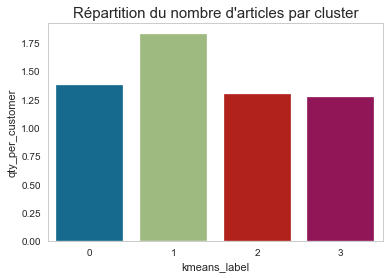

In [125]:
qty_prod.sort_values(by='qty_per_customer', inplace=True)
sns.barplot(x = qty_prod.index,y = qty_prod['qty_per_customer'])
plt.title("Répartition du nombre d'articles par cluster", fontsize=15)

- Le cluster 1 correspond aux clients qui achète le plus d'articles.

In [126]:
#Les clients ayant acheté le plus de produits
print("Nombre de clients ayant acheté 1 produit :" +str(X_rfm_rs[X_rfm_rs['Avg_qty_prod_order'] ==1].shape[0]))
print("Nombre de clients ayant achetés 2 produits :" +str(X_rfm_rs[X_rfm_rs['Avg_qty_prod_order'] ==2].shape[0]))
print("Nombre de clients ayant achetés 3 produits :" +str(X_rfm_rs[X_rfm_rs['Avg_qty_prod_order'] ==3].shape[0]))
print("Nombre de clients ayant achetés 4 produits :" +str(X_rfm_rs[X_rfm_rs['Avg_qty_prod_order'] ==4].shape[0]))
print("Nombre de clients ayant achetés 5 produits :" +str(X_rfm_rs[X_rfm_rs['Avg_qty_prod_order'] ==5].shape[0]))
print("Nombre de clients ayant achetés 6 produits :" +str(X_rfm_rs[X_rfm_rs['Avg_qty_prod_order'] ==6].shape[0]))
print("Nombre de clients ayant achetés plus de 6 produits :" +str(X_rfm_rs[X_rfm_rs['Avg_qty_prod_order'] >6].shape[0]))

Nombre de clients ayant acheté 1 produit :85676
Nombre de clients ayant achetés 2 produits :14046
Nombre de clients ayant achetés 3 produits :3534
Nombre de clients ayant achetés 4 produits :1792
Nombre de clients ayant achetés 5 produits :895
Nombre de clients ayant achetés 6 produits :1026
Nombre de clients ayant achetés plus de 6 produits :510


## Les  longs délais depuis la dernière commande 

In [127]:
long_purchase_delay = X_rfm_rs.drop(['review_score_mean', 'Avg_purchases', 'Avg_qty_prod_order'], 
                      axis=1).groupby('kmeans_label').sum()

In [128]:
long_purchase_delay.columns = ['long_purchase_delay']

In [129]:
#long_purchase_delay

In [130]:
long_purchase_delay['number_of_customers'] = X_rfm_rs.groupby('kmeans_label').count().mean(axis=1)

In [131]:
long_purchase_delay['delay_per_customer'] = long_purchase_delay['long_purchase_delay']/long_purchase_delay['number_of_customers']

In [132]:
#long_purchase_delay

Text(0.5, 1.0, 'Répartition des délais entre deux commandes par cluster')

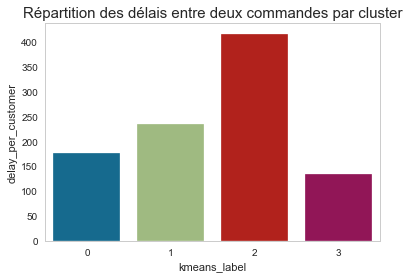

In [133]:
long_purchase_delay.sort_values(by='delay_per_customer', inplace=True)
sns.barplot(x = long_purchase_delay.index,y = long_purchase_delay['delay_per_customer'])
plt.title("Répartition des délais entre deux commandes par cluster", fontsize=15)

- Le cluster 2 correspond aux clients qui ont un délai long entre deux commandes.

In [134]:
#Caratéristiques des clients selon les features du cluster 2
cluster[2].describe()

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay,kmeans_label
count,30289.000000,30289.000000,30289.000000,30289.000000,30289.0
mean,4.720834,146.385895,1.299341,415.918815,2.0
std,0.519156,218.274220,0.863769,88.167422,0.0
min,3.000000,2.290000,1.000000,265.000000,2.0
25%,5.000000,48.900000,1.000000,343.000000,2.0
50%,5.000000,89.900000,1.000000,406.000000,2.0
75%,5.000000,159.900000,1.000000,481.000000,2.0
max,5.000000,6735.000000,15.000000,694.000000,2.0


## On va regarder les clients qui ont donnés une bonne note

In [135]:
good_review_score = X_rfm_rs.drop(['last_purchase_delay', 'Avg_purchases', 'Avg_qty_prod_order'], 
                      axis=1).groupby('kmeans_label').sum()

In [136]:
good_review_score.columns = ['good_grade']

In [137]:
#good_review_score

In [138]:
good_review_score['number_of_customers'] = X_rfm_rs.groupby('kmeans_label').count().mean(axis=1)

In [139]:
good_review_score['grade_per_customer'] = good_review_score['good_grade']/good_review_score['number_of_customers']

In [140]:
good_review_score

,good_grade,number_of_customers,grade_per_customer
kmeans_label,,,
0,84773.833333,23335.0,3.632905
1,19815.000000,15926.0,1.244192
2,142989.333333,30289.0,4.720834
3,199018.000000,39863.0,4.992549


Text(0.5, 1.0, 'Répartition des notes par cluster')

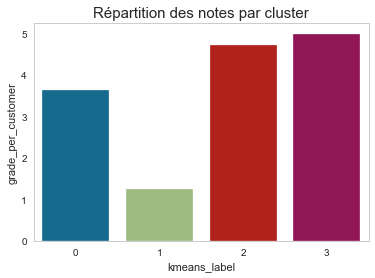

In [141]:
good_review_score.sort_values(by='grade_per_customer', inplace=True)
sns.barplot(x = good_review_score.index,y = good_review_score['grade_per_customer'])
plt.title("Répartition des notes par cluster", fontsize=15)

- Le cluster 3 correspond aux clients qui ont donné le plus de bonne note. A contrario, le cluster ayant les clients qui ont donné le plus de mauvaise note est le cluster 1.

In [142]:
#Caratéristiques des clients selon les features du cluster 2
cluster[3].describe()

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay,kmeans_label
count,39863.000000,39863.000000,39863.000000,39863.000000,39863.0
mean,4.992549,140.079391,1.266236,134.537165,3.0
std,0.061336,201.899028,0.761861,80.854226,0.0
min,4.250000,0.850000,1.000000,0.000000,3.0
25%,5.000000,48.900000,1.000000,64.000000,3.0
50%,5.000000,89.900000,1.000000,130.000000,3.0
75%,5.000000,152.450000,1.000000,204.000000,3.0
max,5.000000,4590.000000,10.000000,277.000000,3.0


In [143]:
#Les clients ayant donné la meilleur note
print("Nombre de clients ayant donné 5/5 :" +str(X_rfm_rs[X_rfm_rs['review_score_mean'] ==5].shape[0]))
#Les clients ayant donné entre 5 et 0
print("Nombre de clients ayant donné 4/5 :" +str(X_rfm_rs[X_rfm_rs['review_score_mean'] ==4].shape[0]))
print("Nombre de clients ayant donné 3/5 :" +str(X_rfm_rs[X_rfm_rs['review_score_mean'] ==3].shape[0]))
print("Nombre de clients ayant donné 2/5 :" +str(X_rfm_rs[X_rfm_rs['review_score_mean'] ==2].shape[0]))
print("Nombre de clients ayant donné 1/5 :" +str(X_rfm_rs[X_rfm_rs['review_score_mean'] ==1].shape[0]))
#Les clients ayant donné la pire note
print("Nombre de clients ayant donné 0/5 :" +str(X_rfm_rs[X_rfm_rs['review_score_mean'] ==0].shape[0]))

Nombre de clients ayant donné 5/5 :61984
Nombre de clients ayant donné 4/5 :20622
Nombre de clients ayant donné 3/5 :9105
Nombre de clients ayant donné 2/5 :3590
Nombre de clients ayant donné 1/5 :12029
Nombre de clients ayant donné 0/5 :0


In [144]:
# % de clients qui sont très satisfait de leur produit
print("% de clients très satisfait :" +str((X_rfm_rs[X_rfm_rs['review_score_mean'] >=4].shape[0])/len(X_rfm_rs)))

% de clients très satisfait :0.7641139535521373


In [145]:
# % de clients qui sont très insatisfait de leur produit
print("% de clients très insatisfait :" +str((X_rfm_rs[X_rfm_rs['review_score_mean'] <=2].shape[0])/len(X_rfm_rs)))

% de clients très insatisfait :0.1441510606600678


### Observations des clients

- les clients qui dépensent le plus, ce sont également ceux qui donnent une moins bonne note, voir mauvaise.
- Ils rachètent  pas très régulièrement mais ils commandent beaucoup d'articles. les délais depuis la derniere commmande sont relativements longs.
    - les clients ayant achetés 1 produit sont 85676 soit 78,3%;
    - les clients ayant achetés 2 produits sont 14046 soit 12,8%;
    - les clients ayant achetés plus de 2 produits sont 7757 soit 7,1%;
- A contrario, ceux qui dépensent le moins, sont ceux qui donnent la meilleure note à leur commande.
- Les clients qui ont un long délai depuis leur derniere commande, annotent une bonne note à cette dernière.
    - Plus de 76% des clients sont satisfaits de leur commande (note 4 et 5);
    - Environ de 14,5% des clients sont insatisfaits de leur commande (note 2,1 et 0);


## Interprétation des clusters en les caratérisants

On va chercher maintenant  les différences entre cluster pour pouvoir avoir une interprétation des métiers. 
- On va utiliser des graphes bivariés.
- On va utiliser "Polar chart with Plotly Express" ( Un diagramme polaire représente des données le long d'axes radiaux et angulaires).
https://plotly.com/python/radar-chart/#basic-radar-chart-with-goscatterpolar

### Analyses bivariées

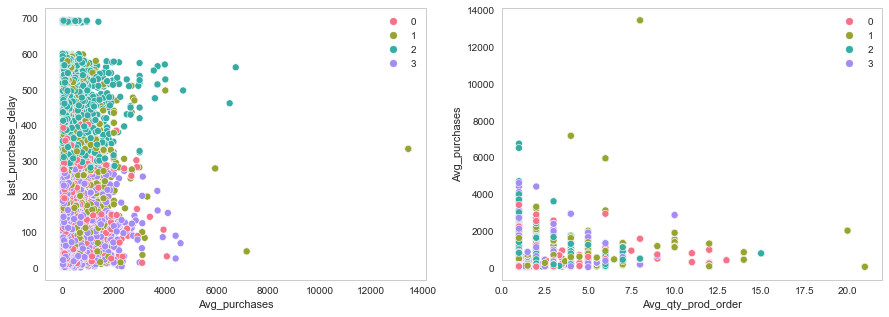

In [146]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_rs["Avg_purchases"],y=X_rfm_rs["last_purchase_delay"],hue=kmeans_labels, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du montant des achats en fonction du délai de livraison", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_rs["Avg_qty_prod_order"],y=X_rfm_rs["Avg_purchases"],hue=kmeans_labels, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du nombre de produits par commande en fonction du montant des achats", fontsize=16)
plt.show()

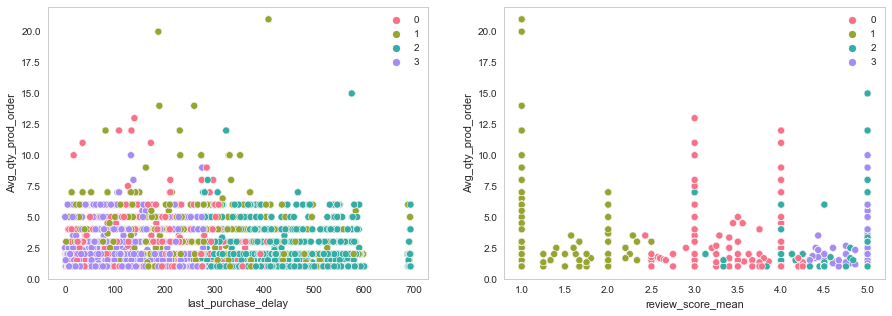

In [147]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_rs["last_purchase_delay"],y=X_rfm_rs["Avg_qty_prod_order"],hue=kmeans_labels, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_rs["review_score_mean"],y=X_rfm_rs["Avg_qty_prod_order"],hue=kmeans_labels, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

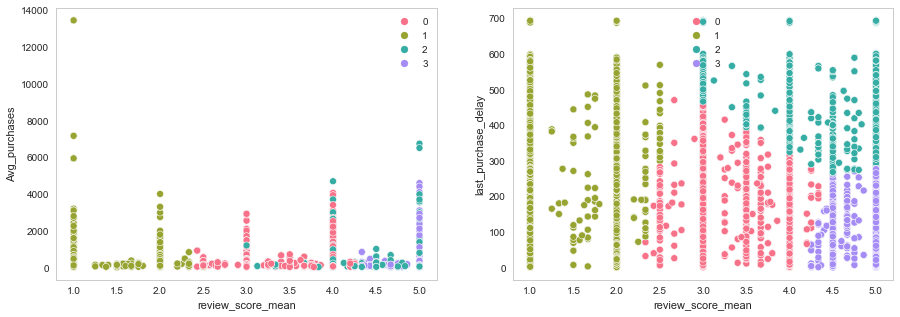

In [148]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_rs["review_score_mean"],y=X_rfm_rs["Avg_purchases"],hue=kmeans_labels, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_rs["review_score_mean"],y=X_rfm_rs["last_purchase_delay"],hue=kmeans_labels, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

###  Diagramme polaire 
Un diagramme polaire représente des données le long d'axes radiaux et angulaires. Avec Plotly Express, il est possible de représenter les données polaires sous forme de marqueurs de dispersion avec px.scatter_polar et sous forme de lignes avec px.line_polar. Les coordonnées radiales et angulaires sont données avec les arguments r et thêta de px.scatter_polar. https://plotly.com/python/polar-chart/

In [149]:
def radar_charts(data, group):

    mms = MinMaxScaler()
    data = pd.DataFrame(mms.fit_transform(data), index=data.index,columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(r=data[data[group]==k].iloc[:,1:].values.reshape(-1),#définit les coordonnées radiales
                                      theta=data.columns[1:],#définit les coordonnées angulaires
                                      fill='toself',#définit la zone à remplir avec une couleur unie
                                      name='Cluster '+str(k)#le nom de la trace apparaît comme élément de légende et au survol
                                        ))
        fig.update_layout(
            polar=dict(
            radialaxis=dict(
              visible=True
                        )), 
            showlegend=True)
#fig.update_layout(showlegend=True)

    fig.show()

In [150]:
radar_charts(X_scaled_groupe, "kmeans_label")

## Interprétation métier des clusters

- Cluster 0 : Clients ayant de courts délais depuis le dernier achat pour des montants faible. Ils commandent moyennement peu d'articles à chaque commande. Les avis de ces clients sont très bons.
- Cluster 1 : Ce sont des clients avec de très bons avis.
- Cluster 2 : Clients ayant de moyens délais depuis le dernier achat pour des montants élévés. Ils commandent beaucoup d'articles à chaque commande. Les avis de ces clients sont très mauvais.
- Cluster 3 : Clients ayant de longs délais depuis le dernier achat pour des montants faible. Ils commandent peu d'articles à chaque commande. Les avis de ces clients sont très bon.

## 3-DBSCAN Clustering avec Dataset RFM élargi

hyperparamètres:
- eps : la dimension du voisinage, c’est-à-dire la distance maximale entre deux observations permettant de les considérer comme voisines l’une de l’autre;

- min_samples : le nombre minimal de voisins que doit avoir un point central.

In [34]:
X_rfm_db = X.copy(deep=True)
X_rfm_db= X_rfm_db.drop(['payment_sequential_count', 'payment_installments_sum','sales', 'Avg_delivery',
                         'order_purchase_timestamp'], axis=1)
X_rfm_db = X_rfm_db.sample(10000, random_state=42).copy(deep=True)
#graphs de scatters
X_db = X_rfm_db.copy(deep=True)

In [35]:
X.shape

(109413, 9)

In [37]:
X_rfm_dbn = MinMaxScaler().fit_transform(X_rfm_db)

DBScan parameters, eps = 0.08 and min_samples=45
Estimated number of clusters: 5
Estimated number of noise points: 624
Silhouette Coefficient: 0.271
Durée d'exécution :0:00:21.737359




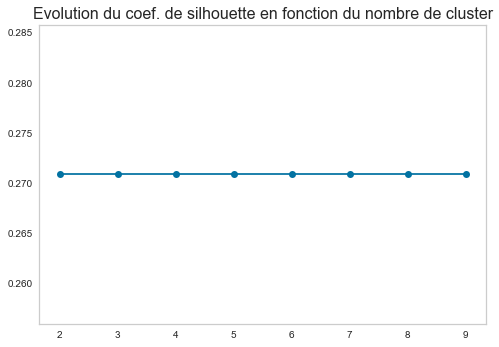

In [38]:
from sklearn import cluster, metrics
import time
from datetime import timedelta
start_time = time.monotonic()

silhouettes_db = []
for num_cluster in range(2,10):

    #cls_db = cluster.DBSCAN(eps=0.08, min_samples=45)
    cls_db = DBSCAN(eps=0.08, min_samples=45).fit(X_rfm_dbn)
    #cls_db.fit(X_rfm_dbn) #on va faire le clustering sur les données normalisées
    labels_db = cls_db.labels_
    #X_rfm_db["dbscan_label"] = labels_db
    #silh_db = metrics.silhouette_score(X_rfm_db, cls_db.labels_)
    silh_db = metrics.silhouette_score(X_rfm_dbn,  labels_db)
    silhouettes_db.append(silh_db)
plt.title("Evolution du coef. de silhouette en fonction du nombre de cluster", fontsize=16)    
plt.plot(range(2,10), silhouettes_db, marker='o')
k_db=len(set(labels_db))-1
#print("K :"+str(k_db))
n_noise_ = list(labels_db).count(-1)
print("DBScan parameters, eps = 0.08 and min_samples=45")
print("Estimated number of clusters: %d" % k_db)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % silh_db)


end_time = time.monotonic()
print("Durée d'exécution :" +str(timedelta(seconds=end_time - start_time)))
print("")
print("")

Le coef de silhouette ne varie pas avec le nombre de cluster. Ce graphique indique qu'il nous faut priviléger de 2 à 9 clusters. On va se baser sur le calcul du nombre de cluster et on va prendre K=4.

In [119]:
X_rfm_db.head(2)

,review_score_mean,Avg_purchases,Avg_qty_prod_order,last_purchase_delay,dbscan_label
customer_unique_id,,,,,
43c32e42823618e190055ee638d41ab1,5.0,214.50,1.0,360.0,0
b1a1d5fdec65cd4c2157493843991df7,5.0,42.98,2.0,350.0,0



### On va visualiser les clusters déterminés par DBSCAN :

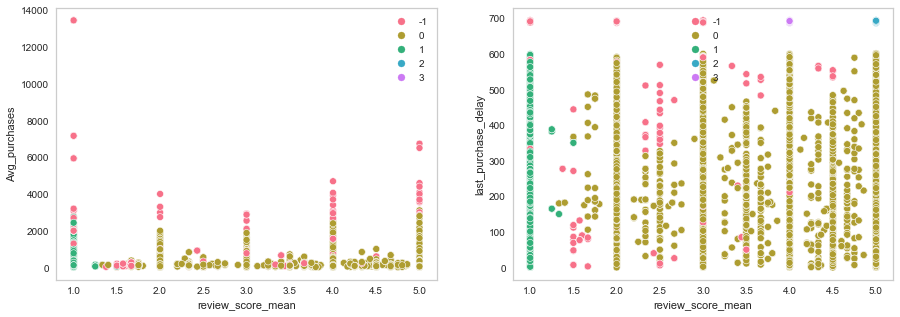

In [120]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_db["review_score_mean"],y=X_rfm_db["Avg_purchases"],hue=labels_db, legend='full', palette=sns.color_palette("husl",5))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_db["review_score_mean"],y=X_rfm_db["last_purchase_delay"],hue=labels_db, legend='full', palette=sns.color_palette("husl",5))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

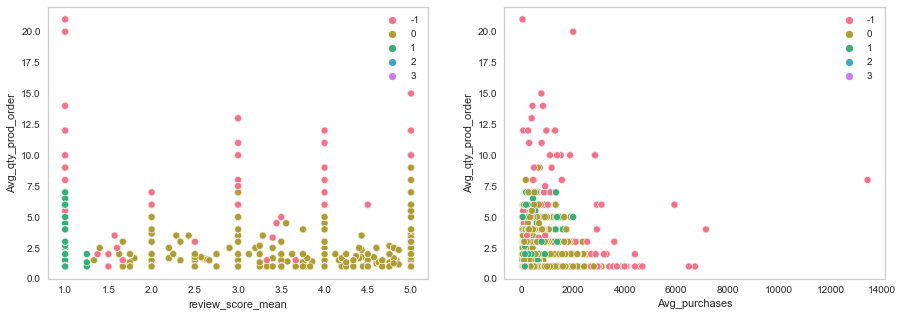

In [121]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_db["review_score_mean"],y=X_rfm_db["Avg_qty_prod_order"],hue=labels_db, legend='full', palette=sns.color_palette("husl",5))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_db["Avg_purchases"],y=X_rfm_db["Avg_qty_prod_order"],hue=labels_db, legend='full', palette=sns.color_palette("husl",5))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

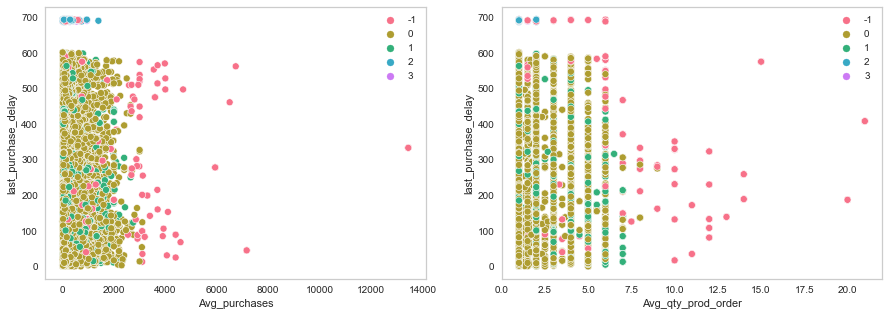

In [122]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_db["Avg_purchases"],y=X_rfm_db["last_purchase_delay"],hue=labels_db, legend='full', palette=sns.color_palette("husl",5))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_db["Avg_qty_prod_order"],y=X_rfm_db["last_purchase_delay"],hue=labels_db, legend='full', palette=sns.color_palette("husl",5))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

Les clusters de cet exemple d'ensemble de données n'ont pas réellement de formes arbitraires. Mais DBSCAN a très bien réussi à détecter les valeurs aberrantes, ce qui ne serait pas facile avec des techniques de clustering basées sur la partition (par exemple, k-means) ou hiérarchiques (par exemple, agglomératives).

## Interprétation métier des clusters via DBSCAN

- Cluster 0 : Clients ayant des montants faible. Ils commandent moyennement peu d'articles à chaque commande. Les avis de ces clients sont moyennements bons.
- Cluster 1 : Ce sont des clients avec de très mauvais avis et des montants faible. Ils commandent moyennement peu d'articles à chaque commande. 
- Cluster 2 : Clients ayant des délais élevés.
- Cluster 3 : Clients ayant des délais élevés.
- Cluster -1: Ce sont des clients avec de bons avis et des montants élevés. Ils commandent beaucoup d'articles à chaque commande. 

## 4-Clustering Hiérarchique avec dataset élargi

In [41]:
X_rfm_ach = X.copy(deep=True)
X_rfm_ach= X_rfm_ach.drop(['payment_sequential_count', 'payment_installments_sum','sales', 'Avg_delivery',
                         'order_purchase_timestamp'], axis=1)
X_rfm_ach = X_rfm_ach.sample(10000, random_state=42).copy(deep=True)
#graphs de scatters
X_ach = X_rfm_ach.copy(deep=True)

### Plot Hierarchical Clustering Dendrogram

- Cet exemple trace le dendrogramme correspondant d'un clustering hiérarchique à l'aide d'AgglomerativeClustering et de la méthode dendrogramme disponible dans scipy.
- Les dendogrammes sont utilisés pour diviser un cluster donné en plusieurs clusters différents.

In [69]:
import time
from datetime import timedelta
start_time = time.monotonic()
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=4)

model = model.fit(X_rfm_ach)
labels_ac = model.labels_
silh_ach = metrics.silhouette_score(X_rfm_ach, labels_ac)
X_rfm_ach["aggloclust_label"] = labels_ac
print("AgglomerativeClustering parameters, n_clusters = 4")
print("Estimated number of clusters: %d" % len(set(labels_ac)))
print("Silhouette Coefficient: %0.3f" % silh_ach)
print("")
print("")
end_time =time.monotonic()
print("Durée d'exécution :" +str(timedelta(seconds=end_time - start_time)))
print("")
print("")

AgglomerativeClustering parameters, n_clusters = 4
Estimated number of clusters: 4
Silhouette Coefficient: 0.439


Durée d'exécution :0:00:04.938278




In [61]:
set(labels_ac)

{0, 1, 2, 3}

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

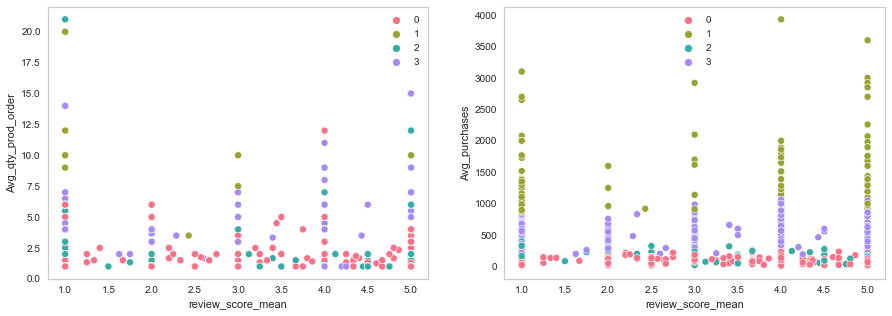

In [48]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_ach["review_score_mean"],y=X_rfm_ach["Avg_qty_prod_order"],hue=labels_ac, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_ach["review_score_mean"],y=X_rfm_ach["Avg_purchases"],hue=labels_ac, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

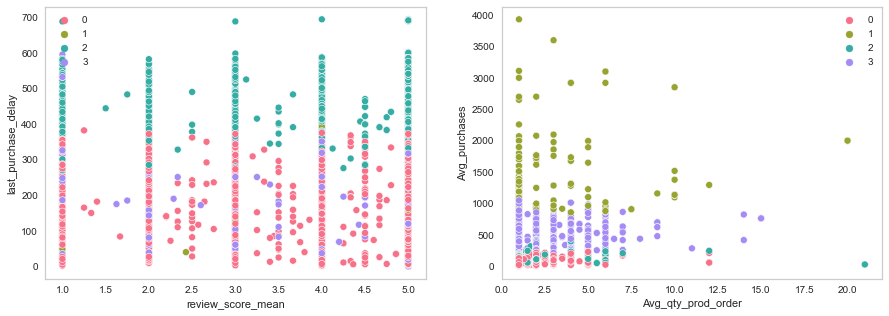

In [49]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_ach["review_score_mean"],y=X_rfm_ach["last_purchase_delay"],hue=labels_ac, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_ach["Avg_qty_prod_order"],y=X_rfm_ach["Avg_purchases"],hue=labels_ac, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

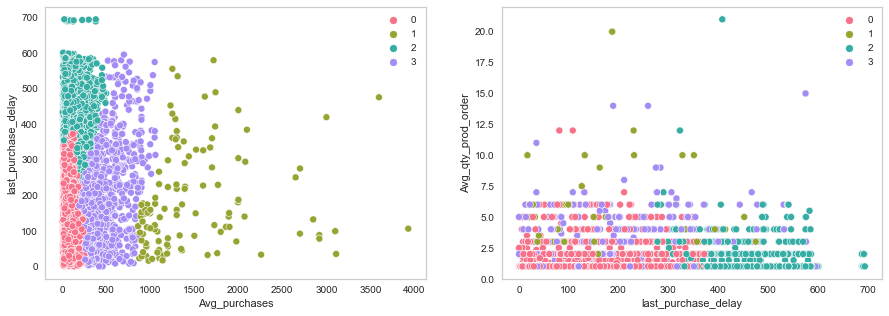

In [51]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.scatterplot(x=X_rfm_ach["Avg_purchases"],y=X_rfm_ach["last_purchase_delay"],hue=labels_ac, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
fig.add_subplot(122)
sns.scatterplot(x=X_rfm_ach["last_purchase_delay"],y=X_rfm_ach["Avg_qty_prod_order"],hue=labels_ac, legend='full', palette=sns.color_palette("husl",4))
#plt.title("Répartition du délai de livraison en fonction du nombre de produits par commande", fontsize=16)
plt.show()

## Interprétation métier des clusters via Hierarchical Clustering

- Cluster 0 : Clients ayant de courts délais depuis le dernier achat pour des montants faible. Ils commandent moyennement peu d'articles à chaque commande. Les avis de ces clients sont très bons.
- Cluster 1 : Ils commandent beaucoup d'articles à chaque commande avec des montants élevés.Ce sont des clients avec des avis moyennements bons.
- Cluster 2 : Clients ayant des délais élevés depuis le dernier achat pour des montants faibles. Ils commandent peu d'articles à chaque commande. Les avis de ces clients sont très moyennes.
- Cluster 3 : Clients ayant des délais relativement moyennes depuis le dernier achat pour des montants faible. Ils commandent moyennement élévés d'articles à chaque commande. Les avis de ces clients sont très bonnes.